<a href="https://colab.research.google.com/github/TiltedCoding/Thesis_/blob/main/Summary_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 12.4 MB/s 
     |████████████████████████████████| 7.6 MB 83.5 MB/s 


In [6]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 12.9 MB/s 


In [7]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig, pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from datasets import load_metric
rouge = load_metric('rouge')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  # This is added back by InteractiveShellApp.init_path()


In [10]:
dataset = load_dataset("xsum")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [12]:
df = pd.DataFrame(dataset['validation'])

In [13]:
df = df.head(30)

In [14]:
df.head(5)

,document,summary,id
0,The ex-Reading defender denied fraudulent trad...,Former Premier League footballer Sam Sodje has...,38295789
1,Voges was forced to retire hurt on 86 after su...,Middlesex batsman Adam Voges will be out until...,40202028
2,Seven photographs taken in the Norfolk country...,The Duchess of Cambridge will feature on the c...,36177725
3,"Chris Poole - known as ""moot"" online - created...",Google has hired the creator of one of the web...,35751255
4,Four police officers were injured in the incid...,Two teenagers have been charged in connection ...,35275743


In [15]:
df.document[0]

'The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.\nMr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42.\nAppearing at the Old Bailey earlier, all four denied the offence.\nThe charge relates to offences which allegedly took place between 2008 and 2014.\nSam, from Kent, Efe and Bright, of Greater Manchester, and Stephen, from Bexley, are due to stand trial in July.\nThey were all released on bail.'

In [16]:
#for i in range(len(df)):
## df['document'][i] = df['document'][i].replace('\n', '')
#  df['document'][i] = re.sub(' +', ' ', df['document'][i])
 # df['summary'][i] = df['summary'][i].replace('\n', '')
 # df['summary'][i] = df['summary'][i].strip()
 # df['summary'][i] = re.sub(' +', ' ', df['document'][i])

In [17]:
# BART Model Summarization.

In [18]:
# Initialize column for Bart Summary to be stored in.
df['BartSummary'] = 0

In [19]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
for i in range(len(df)):
  try:
    text = df['document'][i]
    inputs = tokenizer([text], return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], max_length=500, early_stopping=False)
    final = [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]
    df['BartSummary'][i] = final
  except:
    print(f'Broke for id {i}')

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
# Pipeline simple model

In [21]:
# Initialize Column for the pipeline Summary to be stored in. 
df['PipelineSummary'] = 0

In [22]:
summarizer = pipeline('summarization')
for i in range(len(df)):
  try:
    text = df['document'][i]
    df['PipelineSummary'][i] = summarizer(text, do_sample=False)
  except:
    print(f'Broke for id {i}')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Your max_length is set to 142, but you input_length is only 123. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
Your max_length is set to 142, but you input_length is only 78. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 142, but you input_length is only 71. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 142, but you input_length is only 33. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 142, but you input_length is only 114. You might consider de

In [23]:
# Pipeline meeting fine tuned Bart Based Summarizer.

In [24]:
# Initialize columns for the fine tuned model summaries to be stored in.
df['MeetingSummary'] = 0

In [25]:
summarizer_model = 'knkarthick/MEETING_SUMMARY'
summarizer = pipeline('summarization', model=summarizer_model)
for i in range(len(df)):
  try:
    text = df['document'][i]
    df['MeetingSummary'][i] = summarizer(text, do_sample=False)
  except:
    print(f'Broke for id {i}')

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Your max_length is set to 62, but you input_length is only 33. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


In [26]:
# Pegasus Summary

In [27]:
# Spacy Extractive Summarization.

In [28]:
df['SpaceySummary'] = 0

In [29]:
stopwords = list(STOP_WORDS)
nlp = spacy.load('en_core_web_sm')
for i in range(len(df)):
  try:
    text = df['document'][i] 
    doc = nlp(text)
    tokens = [token.text for token in doc]
    #punctuation = punctuation + "\n"
    word_frequencies = {}
    for word in doc:
      if word.text.lower() not in stopwords:
        if word.text.lower() not in punctuation:
          if word.text not in word_frequencies.keys():
            word_frequencies[word.text] = 1
          else:
            word_frequencies[word.text] += 1
    max_freq = max(word_frequencies.values())
    for word in word_frequencies.keys():
      word_frequencies[word] = word_frequencies[word]/max_freq
    sentence_tokens = [sent for sent in doc.sents]
    sent_score = {}
    for sent in sentence_tokens:
      for word in sent:
        if word.text.lower() in word_frequencies.keys():
          if sent not in sent_score.keys():
            sent_score[sent] = word_frequencies[word.text.lower()]
          else:
            sent_score[sent] += word_frequencies[word.text.lower()]
    select_len = int(len(sentence_tokens)*0.3)
    text_summary = nlargest(select_len, sent_score, key = sent_score.get)
    summary = [word.text for word in text_summary]
    final = ' '.join(summary)
    df['SpaceySummary'][i] = final
  except:
    print(f'Broke for id {i}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
for i in range(len(df)):
  df['BartSummary'][i] = df['BartSummary'][i][0].strip()
  df['PipelineSummary'][i] = df['PipelineSummary'][i][0]['summary_text'].strip()
  df['MeetingSummary'][i] = df['MeetingSummary'][i][0]['summary_text'].strip()

In [31]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [33]:
df['PegasusSummary'] = 0

In [34]:
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
for i in range(len(df)):
  try:
    text = df['document'][i]
    inputs = tokenizer(text, return_tensors='pt')
    summary_ids = model.generate(**inputs)
    final = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    df['PegasusSummary'][i] = final
  except:
    print(f'Broke for id {i}')

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1301: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
Token indices sequence length is longer than the specified maximum sequence length for this model (953 > 512). Running this sequence through the model will result in indexing errors


Broke for id 9
Broke for id 10
Broke for id 17
Broke for id 27


In [35]:
df['PegasusSummary']

0     Former Premier League footballer Sam Sodje has...
1     Middlesex batsman Adam Voges will miss the res...
2     The Duchess of Cambridge is to feature on the ...
3     The founder of notorious online forum 4chan ha...
4     Two teenagers have been charged in connection ...
5     A pedestrian has been taken to hospital after ...
6     Barcelona president Sandro Rosell has resigned...
7     Schools in London face a 10% funding cut by 20...
8     England opener Jason Roy hit his third century...
9                                                     0
10                                                    0
11    The Taoiseach (Irish prime minister) Enda Kenn...
12    Kent's Police and Crime Commissioner (PCC) has...
13    An eight-year-old boy has been grabbed by a ma...
14    Newport County goalkeeper Rhys Taylor has join...
15    New Mills Town and Bashley have become the fir...
16    A referendum on whether Bath and North East So...
17                                              

In [36]:
# Check to see is summary is different than the document (It was the same in one try and was trying to figure out why)
df['summary'] == df['document']

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
dtype: bool

In [37]:
# Evalution for the summaries using Rouge Metric.

In [38]:
# Initialize columns for Bart evaluation to be stored in. 
df['Bartrouge1acc'] = 0.0
df['Bartrouge1rec'] = 0.0
df['Bartrouge1f1'] = 0.0
df['Bartrouge2acc'] = 0.0
df['Bartrouge2rec'] = 0.0
df['Bartrouge2f1'] = 0.0
df['BartrougeLacc'] = 0.0
df['BartrougeLrec'] = 0.0
df['BartrougeLf1'] = 0.0
df['BartrougeLsumacc'] = 0.0
df['BartrougeLsumrec'] = 0.0
df['BartrougeLsumf1'] = 0.0
# Initialize columns for Pipeline evaluation to be stored in. 
df['Pipelinerouge1acc'] = 0.0
df['Pipelinerouge1rec'] = 0.0
df['Pipelinerouge1f1'] = 0.0
df['Pipelinerouge2acc'] = 0.0
df['Pipelinerouge2rec'] = 0.0
df['Pipelinerouge2f1'] = 0.0
df['PipelinerougeLacc'] = 0.0
df['PipelinerougeLrec'] = 0.0
df['PipelinerougeLf1'] = 0.0
df['PipelinerougeLsumacc'] = 0.0
df['PipelinerougeLsumrec'] = 0.0
df['PipelinerougeLsumf1'] = 0.0
# Initialize columns for Meeting fine tuned evaluation to be stored in. 
df['Meetingrouge1acc'] = 0.0
df['Meetingrouge1rec'] = 0.0
df['Meetingrouge1f1'] = 0.0
df['Meetingrouge2acc'] = 0.0
df['Meetingrouge2rec'] = 0.0
df['Meetingrouge2f1'] = 0.0
df['MeetingrougeLacc'] = 0.0
df['MeetingrougeLrec'] = 0.0
df['MeetingrougeLf1'] = 0.0
df['MeetingrougeLsumacc'] = 0.0
df['MeetingrougeLsumrec'] = 0.0
df['MeetingrougeLsumf1'] = 0.0
# Initialize columns for Spacey evaluation to be stored in. 
df['Spaceyrouge1acc'] = 0.0
df['Spaceyrouge1rec'] = 0.0
df['Spaceyrouge1f1'] = 0.0
df['Spaceyrouge2acc'] = 0.0
df['Spaceyrouge2rec'] = 0.0
df['Spaceyrouge2f1'] = 0.0
df['SpaceyrougeLacc'] = 0.0
df['SpaceyrougeLrec'] = 0.0
df['SpaceyrougeLf1'] = 0.0
df['SpaceyrougeLsumacc'] = 0.0
df['SpaceyrougeLsumrec'] = 0.0
df['SpaceyrougeLsumf1'] = 0.0
# Initialize columns for Pegasus evaluation to be stored in. 
df['Pegasusrouge1acc'] = 0.0
df['Pegasusrouge1rec'] = 0.0
df['Pegasusrouge1f1'] = 0.0
df['Pegasusrouge2acc'] = 0.0
df['Pegasusrouge2rec'] = 0.0
df['Pegasusrouge2f1'] = 0.0
df['PegasusrougeLacc'] = 0.0
df['PegasusrougeLrec'] = 0.0
df['PegasusrougeLf1'] = 0.0
df['PegasusrougeLsumacc'] = 0.0
df['PegasusrougeLsumrec'] = 0.0
df['PegasusrougeLsumf1'] = 0.0

In [39]:
for i in range(len(df)):
  pred = [df['BartSummary'][i]]
  ref = [df['summary'][i]]
  df['Bartrouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Bartrouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Bartrouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Bartrouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Bartrouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Bartrouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['BartrougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['BartrougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['BartrougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['BartrougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['BartrougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['BartrougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

In [40]:
# Bart Evaluation
for i in range(len(df)):
  pred = [df['BartSummary'][i]]
  ref = [df['summary'][i]]
  df['Bartrouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Bartrouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Bartrouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Bartrouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Bartrouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Bartrouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['BartrougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['BartrougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['BartrougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['BartrougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['BartrougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['BartrougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

In [41]:
# Simple pipeline model evaluation
for i in range(len(df)):
  pred = [df['PipelineSummary'][i]]
  ref = [df['summary'][i]]
  df['Pipelinerouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Pipelinerouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Pipelinerouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Pipelinerouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Pipelinerouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Pipelinerouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['PipelinerougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['PipelinerougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['PipelinerougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['PipelinerougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['PipelinerougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['PipelinerougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

In [42]:
# Meeting Fine Tuned Summary Evaluation
for i in range(len(df)):
  pred = [df['MeetingSummary'][i]]
  ref = [df['summary'][i]]
  df['Meetingrouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Meetingrouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Meetingrouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Meetingrouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Meetingrouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Meetingrouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['MeetingrougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['MeetingrougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['MeetingrougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['MeetingrougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['MeetingrougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['MeetingrougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

In [43]:
# Spacey Evaluation
for i in range(len(df)):
  pred = [df['SpaceySummary'][i]]
  ref = [df['summary'][i]]
  df['Spaceyrouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Spaceyrouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Spaceyrouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Spaceyrouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Spaceyrouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Spaceyrouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['SpaceyrougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['SpaceyrougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['SpaceyrougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['SpaceyrougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['SpaceyrougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['SpaceyrougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

In [44]:
# Pegasus Evaluation
for i in range(len(df)):
  pred = [df['PegasusSummary'][i]]
  ref = [df['summary'][i]]
  df['Pegasusrouge1acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][0]
  df['Pegasusrouge1rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][1]
  df['Pegasusrouge1f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge1'][0][2]
  df['Pegasusrouge2acc'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][0]
  df['Pegasusrouge2rec'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][1]
  df['Pegasusrouge2f1'][i] = rouge.compute(predictions=pred, references=ref)['rouge2'][0][2]
  df['PegasusrougeLacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][0]
  df['PegasusrougeLrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][1]
  df['PegasusrougeLf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeL'][0][2]
  df['PegasusrougeLsumacc'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][0]
  df['PegasusrougeLsumrec'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][1]
  df['PegasusrougeLsumf1'][i] = rouge.compute(predictions=pred, references=ref)['rougeLsum'][0][2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

In [55]:
print('ROUGE-1 results:')
print(f"Average F1 Scores for each model:\nBart: {np.mean(df['Bartrouge1f1'])}\nPipeline: {np.mean(df['Pipelinerouge1f1'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge1f1'])}\nPegasus: {np.mean(df['Pegasusrouge1f1'])}\nSpacey: {np.mean(df['Spaceyrouge1f1'])}")
print('-------------------------')
print(f"Average Accuracy Scores for each model:\nBart: {np.mean(df['Bartrouge1acc'])}\nPipeline: {np.mean(df['Pipelinerouge1acc'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge1acc'])}\nPegasus: {np.mean(df['Pegasusrouge1acc'])}\nSpacey: {np.mean(df['Spaceyrouge1acc'])}")
print('-------------------------')
print(f"Average Recall Scores for each model:\nBart: {np.mean(df['Bartrouge1rec'])}\nPipeline: {np.mean(df['Pipelinerouge1rec'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge1rec'])}\nPegasus: {np.mean(df['Pegasusrouge1rec'])}\nSpacey: {np.mean(df['Spaceyrouge1rec'])}")

ROUGE-1 results:
Average F1 Scores for each model:
Bart: 0.19359367015365686
Pipeline: 0.2037653686389446
Meeting Fine Tuned: 0.3733467935775472
Pegasus: 0.4165486880303379
Spacey: 0.15706597673330452
-------------------------
Average Accuracy Scores for each model:
Bart: 0.1311608900922523
Pipeline: 0.14437492187523748
Meeting Fine Tuned: 0.406971287038732
Pegasus: 0.4479657191955281
Spacey: 0.10977094839155184
-------------------------
Average Recall Scores for each model:
Bart: 0.39238190013772195
Pipeline: 0.35876861899942625
Meeting Fine Tuned: 0.3674219185274061
Pegasus: 0.40087164338032555
Spacey: 0.3919619285108583


In [56]:
print('ROUGE-1 results:')
print(f"Average F1 Scores for each model for bigrams:\nBart: {np.mean(df['Bartrouge2f1'])}\nPipeline: {np.mean(df['Pipelinerouge2f1'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge2f1'])}\nPegasus: {np.mean(df['Pegasusrouge2f1'])}\nSpacey: {np.mean(df['Spaceyrouge2f1'])}")
print('-------------------------')
print(f"Average Accuracy Scores for each model for bigrams:\nBart: {np.mean(df['Bartrouge2acc'])}\nPipeline: {np.mean(df['Pipelinerouge2acc'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge2acc'])}\nPegasus: {np.mean(df['Pegasusrouge2acc'])}\nSpacey: {np.mean(df['Spaceyrouge2acc'])}")
print('-------------------------')
print(f"Average Recall Scores for each model for bigrams:\nBart: {np.mean(df['Bartrouge2rec'])}\nPipeline: {np.mean(df['Pipelinerouge2rec'])}\nMeeting Fine Tuned: {np.mean(df['Meetingrouge2rec'])}\nPegasus: {np.mean(df['Pegasusrouge2rec'])}\nSpacey: {np.mean(df['Spaceyrouge2rec'])}")

ROUGE-1 results:
Average F1 Scores for each model for bigrams:
Bart: 0.041711966387388076
Pipeline: 0.04021414793054121
Meeting Fine Tuned: 0.17717911614630036
Pegasus: 0.24676737361506268
Spacey: 0.02559515360439983
-------------------------
Average Accuracy Scores for each model for bigrams:
Bart: 0.02698245050298157
Pipeline: 0.027738678735820296
Meeting Fine Tuned: 0.1928540798664301
Pegasus: 0.26314873124487476
Spacey: 0.018099385236686364
-------------------------
Average Recall Scores for each model for bigrams:
Bart: 0.09879998860514408
Pipeline: 0.0751924808970396
Meeting Fine Tuned: 0.17360205768790368
Pegasus: 0.24129716100427726
Spacey: 0.06814241956931642


In [57]:
print(f"ROUGE-L results:\nAverage F1 Scores for each model:\nBart: {np.mean(df['BartrougeLf1'])}\nPipeline: {np.mean(df['PipelinerougeLf1'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLf1'])}\nPegasus: {np.mean(df['PegasusrougeLf1'])}\nSpacey: {np.mean(df['SpaceyrougeLf1'])}")
print('-------------------------')
print(f"Average Accuracy Scores for each model:\nBart: {np.mean(df['BartrougeLacc'])}\nPipeline: {np.mean(df['PipelinerougeLacc'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLacc'])}\nPegasus: {np.mean(df['PegasusrougeLacc'])}\nSpacey: {np.mean(df['SpaceyrougeLacc'])}")
print('-------------------------')
print(f"Average Recall Scores for each model:\nBart: {np.mean(df['BartrougeLrec'])}\nPipeline: {np.mean(df['PipelinerougeLrec'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLrec'])}\nPegasus: {np.mean(df['PegasusrougeLrec'])}\nSpacey: {np.mean(df['SpaceyrougeLrec'])}")

ROUGE-L results:
Average F1 Scores for each model:
Bart: 0.12936374903182463
Pipeline: 0.1441048700398486
Meeting Fine Tuned: 0.31554883984846194
Pegasus: 0.35231206347369654
Spacey: 0.10353002450488655
-------------------------
Average Accuracy Scores for each model:
Bart: 0.08757403006698185
Pipeline: 0.10160854821759785
Meeting Fine Tuned: 0.3456814217195993
Pegasus: 0.38040640297892286
Spacey: 0.07399446133479852
-------------------------
Average Recall Scores for each model:
Bart: 0.2636420598241839
Pipeline: 0.25668932903659425
Meeting Fine Tuned: 0.30887432832427664
Pegasus: 0.3387418640787646
Spacey: 0.24924219514832877


In [58]:
print(f"ROUGE-Lsum results:\nAverage F1 Scores for each model:\nBart: {np.mean(df['BartrougeLsumf1'])}\nPipeline: {np.mean(df['PipelinerougeLsumf1'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLsumf1'])}\nPegasus: {np.mean(df['PegasusrougeLsumf1'])}\nSpacey: {np.mean(df['SpaceyrougeLsumf1'])}")
print('-------------------------')
print(f"Average Accuracy Scores for each model:\nBart: {np.mean(df['BartrougeLsumacc'])}\nPipeline: {np.mean(df['PipelinerougeLsumacc'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLsumacc'])}\nPegasus: {np.mean(df['PegasusrougeLsumacc'])}\nSpacey: {np.mean(df['SpaceyrougeLsumacc'])}")
print('-------------------------')
print(f"Average Recall Scores for each model:\nBart: {np.mean(df['BartrougeLsumrec'])}\nPipeline: {np.mean(df['PipelinerougeLsumrec'])}\nMeeting Fine Tuned: {np.mean(df['MeetingrougeLsumrec'])}\nPegasus: {np.mean(df['PegasusrougeLsumrec'])}\nSpacey: {np.mean(df['SpaceyrougeLsumrec'])}")

ROUGE-Lsum results:
Average F1 Scores for each model:
Bart: 0.12936374903182463
Pipeline: 0.1441048700398486
Meeting Fine Tuned: 0.31554883984846194
Pegasus: 0.35231206347369654
Spacey: 0.12433214028600212
-------------------------
Average Accuracy Scores for each model:
Bart: 0.08757403006698185
Pipeline: 0.10160854821759785
Meeting Fine Tuned: 0.3456814217195993
Pegasus: 0.38040640297892286
Spacey: 0.0866111851250207
-------------------------
Average Recall Scores for each model:
Bart: 0.2636420598241839
Pipeline: 0.25668932903659425
Meeting Fine Tuned: 0.30887432832427664
Pegasus: 0.3387418640787646
Spacey: 0.31381639470078915


In [ ]:
figure(figsize=(16, 10), dpi=80)
polarityplot = sns.countplot(x=df['polarity'],
                             hue=coders.ID)
plt.legend(title= 'Annotator', loc='right', bbox_to_anchor=(1.25, 0.5),
           ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.title('Polarity Per Annotator')
plt.show(polarityplot)

In [ ]:
figure(figsize=(16, 10), dpi=80)
polarityplot = sns.countplot(x=df['polarity'],
                             hue=coders.ID)
plt.legend(title= 'Annotator', loc='right', bbox_to_anchor=(1.25, 0.5),
           ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.title('Polarity Per Annotator')
plt.show(polarityplot)

In [61]:
models_list = ['BART', 'Pipeline', 'Meeting', 'Pegasus', 'Spacey']

In [62]:
models_list

['BART', 'Pipeline', 'Meeting', 'Pegasus', 'Spacey']

In [119]:
rlsumf = [np.mean(df['BartrougeLsumf1']), np.mean(df['PipelinerougeLsumf1']), np.mean(df['MeetingrougeLsumf1']), np.mean(df['PegasusrougeLsumf1']), np.mean(df['SpaceyrougeLsumf1'])]
rlsuma = [np.mean(df['BartrougeLsumacc']), np.mean(df['PipelinerougeLsumacc']), np.mean(df['MeetingrougeLsumacc']), np.mean(df['PegasusrougeLsumacc']), np.mean(df['SpaceyrougeLsumacc'])]
rlsumr = [np.mean(df['BartrougeLsumrec']), np.mean(df['PipelinerougeLsumrec']), np.mean(df['MeetingrougeLsumrec']), np.mean(df['PegasusrougeLsumrec']), np.mean(df['SpaceyrougeLsumrec'])]
rlsumm = ['ROUGE-Lsum', 'ROUGE-Lsum', 'ROUGE-Lsum', 'ROUGE-Lsum', 'ROUGE-Lsum']

In [70]:
rlsuma

[0.08757403006698185,
 0.10160854821759785,
 0.3456814217195993,
 0.38040640297892286,
 0.0866111851250207]

In [60]:
rlsum

[0.12936374903182463,
 0.1441048700398486,
 0.31554883984846194,
 0.35231206347369654,
 0.12433214028600212]

In [106]:
rlf = [np.mean(df['BartrougeLf1']), np.mean(df['PipelinerougeLf1']), np.mean(df['MeetingrougeLf1']), np.mean(df['PegasusrougeLf1']), np.mean(df['SpaceyrougeLf1'])]
rla = [np.mean(df['BartrougeLacc']), np.mean(df['PipelinerougeLacc']), np.mean(df['MeetingrougeLacc']), np.mean(df['PegasusrougeLacc']), np.mean(df['SpaceyrougeLacc'])]
rlr = [np.mean(df['BartrougeLrec']), np.mean(df['PipelinerougeLrec']), np.mean(df['MeetingrougeLrec']), np.mean(df['PegasusrougeLrec']), np.mean(df['SpaceyrougeLrec'])]
rlm = ['ROUGE-L', 'ROUGE-L', 'ROUGE-L', 'ROUGE-L', 'ROUGE-L']

In [64]:
rl_list

[0.12936374903182463,
 0.1441048700398486,
 0.31554883984846194,
 0.35231206347369654,
 0.10353002450488655]

In [107]:
r2f = [np.mean(df['Bartrouge2f1']), np.mean(df['Pipelinerouge2f1']), np.mean(df['Meetingrouge2f1']), np.mean(df['Pegasusrouge2f1']), np.mean(df['Spaceyrouge2f1'])]
r2a = [np.mean(df['Bartrouge2acc']), np.mean(df['Pipelinerouge2acc']), np.mean(df['Meetingrouge2acc']), np.mean(df['Pegasusrouge2acc']), np.mean(df['Spaceyrouge2acc'])]
r2r = [np.mean(df['Bartrouge2rec']), np.mean(df['Pipelinerouge2rec']), np.mean(df['Meetingrouge2rec']), np.mean(df['Pegasusrouge2rec']), np.mean(df['Spaceyrouge2rec'])]
r2m = ['ROUGE-2', 'ROUGE-2', 'ROUGE-2', 'ROUGE-2', 'ROUGE-2']

In [66]:
r2_list

[0.041711966387388076,
 0.04021414793054121,
 0.17717911614630036,
 0.24676737361506268,
 0.02559515360439983]

In [73]:
r1f = [np.mean(df['Bartrouge1f1']), np.mean(df['Pipelinerouge1f1']), np.mean(df['Meetingrouge1f1']), np.mean(df['Pegasusrouge1f1']), np.mean(df['Spaceyrouge1f1'])]
r1a = [np.mean(df['Bartrouge1acc']), np.mean(df['Pipelinerouge1acc']), np.mean(df['Meetingrouge1acc']), np.mean(df['Pegasusrouge1acc']), np.mean(df['Spaceyrouge1acc'])]
r1r = [np.mean(df['Bartrouge1rec']), np.mean(df['Pipelinerouge1rec']), np.mean(df['Meetingrouge1rec']), np.mean(df['Pegasusrouge1rec']), np.mean(df['Spaceyrouge1rec'])]
r1m = ['ROUGE-1', 'ROUGE-1', 'ROUGE-1', 'ROUGE-1', 'ROUGE-1']

In [93]:
r1f

[0.19359367015365686,
 0.2037653686389446,
 0.3733467935775472,
 0.4165486880303379,
 0.15706597673330452]

In [94]:
r1a

[0.1311608900922523,
 0.14437492187523748,
 0.406971287038732,
 0.4479657191955281,
 0.10977094839155184]

In [95]:
r1r

[0.39238190013772195,
 0.35876861899942625,
 0.3674219185274061,
 0.40087164338032555,
 0.3919619285108583]

In [103]:
r1df = pd.DataFrame([r1f, r1a, r1r, models_list, r1m]).T

In [104]:
r1df.columns = ['F1 Score', 'Accuracy', 'Recall', 'Model', 'Metric']

In [105]:
r1df

,F1 Score,Accuracy,Recall,Model,Metric
0,0.193594,0.131161,0.392382,BART,ROUGE-1
1,0.203765,0.144375,0.358769,Pipeline,ROUGE-1
2,0.373347,0.406971,0.367422,Meeting,ROUGE-1
3,0.416549,0.447966,0.400872,Pegasus,ROUGE-1
4,0.157066,0.109771,0.391962,Spacey,ROUGE-1


In [112]:
r2df = pd.DataFrame([r2f, r2a, r2r, models_list, r2m]).T
r2df.columns = ['F1 Score', 'Accuracy', 'Recall', 'Model', 'Metric']

In [113]:
r2df

,F1 Score,Accuracy,Recall,Model,Metric
0,0.041712,0.026982,0.0988,BART,ROUGE-2
1,0.040214,0.027739,0.075192,Pipeline,ROUGE-2
2,0.177179,0.192854,0.173602,Meeting,ROUGE-2
3,0.246767,0.263149,0.241297,Pegasus,ROUGE-2
4,0.025595,0.018099,0.068142,Spacey,ROUGE-2


In [114]:
rldf = pd.DataFrame([rlf, rla, rlr, models_list, rlm]).T
rldf.columns = ['F1 Score', 'Accuracy', 'Recall', 'Model', 'Metric']

In [115]:
rldf

,F1 Score,Accuracy,Recall,Model,Metric
0,0.129364,0.087574,0.263642,BART,ROUGE-L
1,0.144105,0.101609,0.256689,Pipeline,ROUGE-L
2,0.315549,0.345681,0.308874,Meeting,ROUGE-L
3,0.352312,0.380406,0.338742,Pegasus,ROUGE-L
4,0.10353,0.073994,0.249242,Spacey,ROUGE-L


In [120]:
rlsumdf = pd.DataFrame([rlsumf, rlsuma, rlsumr, models_list, rlsumm]).T
rlsumdf.columns = ['F1 Score', 'Accuracy', 'Recall', 'Model', 'Metric']

In [121]:
rlsumdf

,F1 Score,Accuracy,Recall,Model,Metric
0,0.129364,0.087574,0.263642,BART,ROUGE-Lsum
1,0.144105,0.101609,0.256689,Pipeline,ROUGE-Lsum
2,0.315549,0.345681,0.308874,Meeting,ROUGE-Lsum
3,0.352312,0.380406,0.338742,Pegasus,ROUGE-Lsum
4,0.124332,0.086611,0.313816,Spacey,ROUGE-Lsum


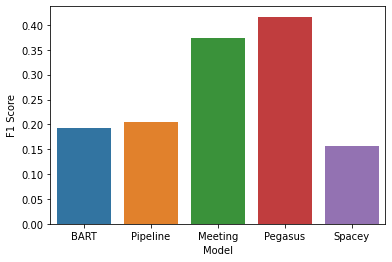

In [128]:
sns.barplot(data=r1df, x='Model', y='F1 Score')

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [129]:
rdf = pd.concat([r1df, r2df, rldf, rlsumdf])

In [130]:
rdf

,F1 Score,Accuracy,Recall,Model,Metric
0,0.193594,0.131161,0.392382,BART,ROUGE-1
1,0.203765,0.144375,0.358769,Pipeline,ROUGE-1
2,0.373347,0.406971,0.367422,Meeting,ROUGE-1
3,0.416549,0.447966,0.400872,Pegasus,ROUGE-1
4,0.157066,0.109771,0.391962,Spacey,ROUGE-1
0,0.041712,0.026982,0.0988,BART,ROUGE-2
1,0.040214,0.027739,0.075192,Pipeline,ROUGE-2
2,0.177179,0.192854,0.173602,Meeting,ROUGE-2
3,0.246767,0.263149,0.241297,Pegasus,ROUGE-2
4,0.025595,0.018099,0.068142,Spacey,ROUGE-2


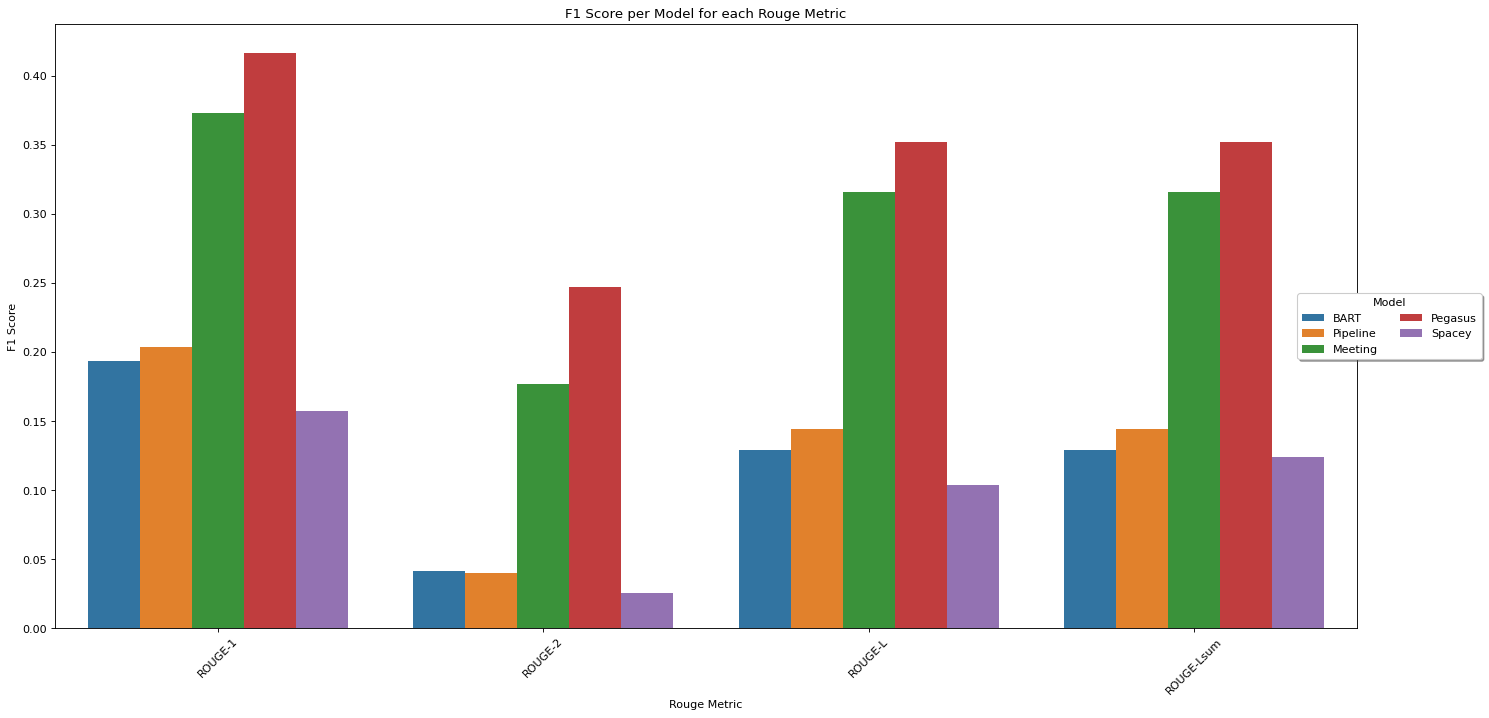

In [145]:
figure = plt.figure(figsize=(21,10), dpi=80)
f1plot = sns.barplot(data=rdf, x='Metric', y='F1 Score', hue='Model')
plt.legend(title= 'Model', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Rouge Metric')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.title('F1 Score per Model for each Rouge Metric')
plt.show(f1plot)

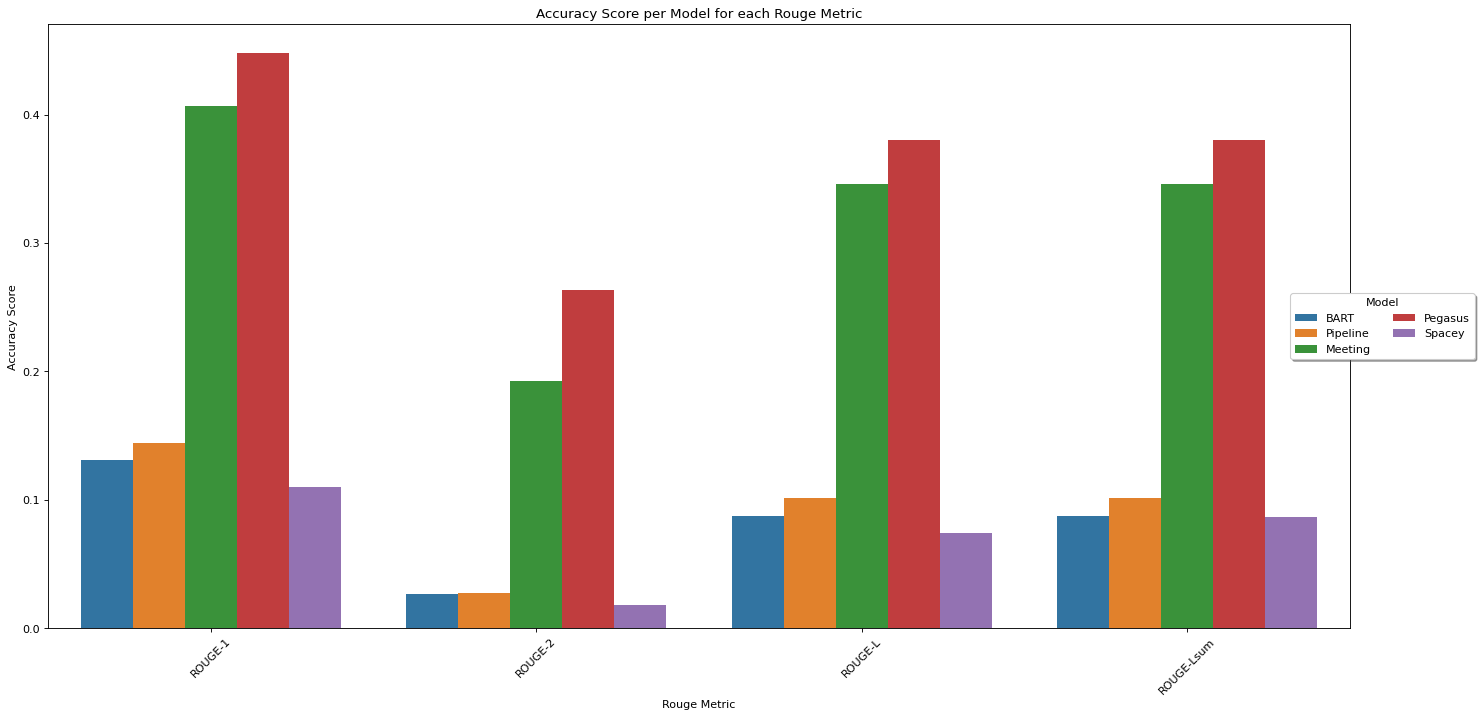

In [146]:
figure = plt.figure(figsize=(21,10), dpi=80)
accplot = sns.barplot(data=rdf, x='Metric', y='Accuracy', hue='Model')
plt.legend(title= 'Model', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Rouge Metric')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.title('Accuracy Score per Model for each Rouge Metric')
plt.show(accplot)

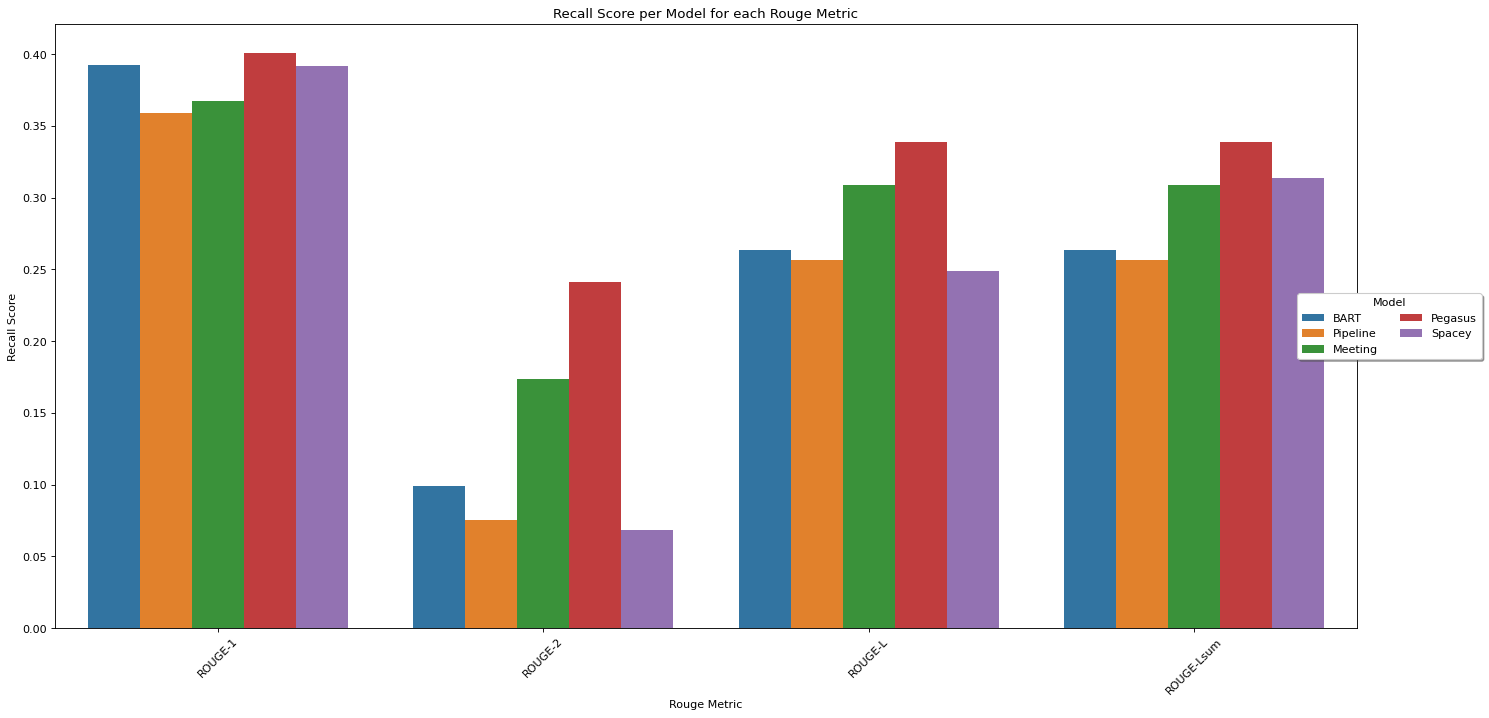

In [147]:
figure = plt.figure(figsize=(21,10), dpi=80)
recplot = sns.barplot(data=rdf, x='Metric', y='Recall', hue='Model')
plt.legend(title= 'Model', loc='right', bbox_to_anchor=(1.10, 0.5),
               ncol = 2, fancybox=True, shadow=True) #https://matplotlib.org/2.0.2/users/legend_guide.html
plt.xlabel('Rouge Metric')
plt.ylabel('Recall Score')
plt.xticks(rotation=45)
plt.title('Recall Score per Model for each Rouge Metric')
plt.show(accplot)